In [1]:
import pickle
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
import random
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
import pandas as pd

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Device: grpc://10.0.0.2:8470
Number of replicas: 8
2.4.1


In [3]:
with open('../input/smart-reply-sentence-similarity/input_texts.pickle', 'rb') as handle:
    input_texts = pickle.load(handle)
    
with open('../input/smart-reply-sentence-similarity/target_texts.pickle', 'rb') as handle:
    output_texts = pickle.load(handle)
    
with open('../input/smart-reply-clustering-output/target_dbscan.pickle', 'rb') as handle:
    dbscan = pickle.load(handle)

In [4]:
print(len(input_texts))
print(len(dbscan.labels_))

5001
5001


In [5]:
dbscan.labels_.shape

(5001,)

In [6]:
input_texts[:10]

['yes it helped him smooth out his dance moves',
 'hi. do you like to dance',
 "yeah good point. he also invented some women's names",
 'do you know how google maps calculates traffic',
 'i am not sure how do they do this',
 'do you like comic books',
 'hi do you like fish',
 'you as well..',
 "doesn't music needs melody .)",
 'lots of rap does have that.']

In [7]:
# fitting tokenizer on all short messages
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(input_texts)
total_words = len(tokenizer.word_index) + 1

In [8]:
input_tokens = tokenizer.texts_to_sequences(input_texts)
input_tokens[:10]

[[15, 12, 961, 152, 962, 178, 120, 153, 1422],
 [14, 2, 1, 8, 13, 153],
 [25, 16, 321, 34, 99, 279, 137, 963, 445],
 [2, 1, 17, 11, 179, 1423, 1424, 964],
 [3, 105, 40, 74, 11, 2, 31, 2, 106],
 [2, 1, 8, 604, 280],
 [14, 2, 1, 8, 226],
 [1, 58, 37],
 [446, 57, 965, 1425],
 [605, 19, 201, 154, 7, 9]]

In [9]:
def generate_padded_sequences(input_sequences):
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(tf.keras.preprocessing.sequence.pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
    
    predictors = input_sequences
    #label = tf.keras.utils.to_categorical(label, num_classes=total_words)
    return predictors, max_sequence_len

predictors, max_sequence_len = generate_padded_sequences(input_tokens)

In [10]:
labels = np.array(dbscan.labels_, copy=True)
labels[labels == -1] = len(set(dbscan.labels_)) - 1
print(labels[:10])

[273 273 273 273 273 273   0   1 273 273]


In [11]:
encoder_labels = OneHotEncoder().fit(labels.reshape(-1, 1))
one_hot_labels = encoder_labels.transform(labels.reshape(-1, 1))
one_hot_labels.shape

(5001, 274)

In [12]:
def create_model(max_sequence_len, total_words):
    input_len = max_sequence_len - 1
    model = tf.keras.Sequential()
    
    # Add Input Embedding Layer
    model.add(tf.keras.layers.Embedding(total_words, 512, input_length=input_len))
    
    # Add Hidden Layer 1 - LSTM Layer
    #model.add(tf.keras.layers.LSTM(256, return_sequences=True))
    #model.add(tf.keras.layers.Dropout(0.2))
    
    model.add(tf.keras.layers.LSTM(512))
    model.add(tf.keras.layers.Dropout(0.2))
    
    # Add Output Layer
    model.add(tf.keras.layers.Dense(one_hot_labels.shape[1], activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
    
    return model


with strategy.scope():
    model = create_model(max_sequence_len, total_words)
    model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 9, 512)            1623040   
_________________________________________________________________
lstm (LSTM)                  (None, 512)               2099200   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 274)               140562    
Total params: 3,862,802
Trainable params: 3,862,802
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = model.fit(predictors, one_hot_labels.todense(), epochs=25, verbose=1)

Epoch 1/25
157/157 [==============================] - 10s 30ms/step - loss: 2.5511 - accuracy: 0.7069
Epoch 2/25
157/157 [==============================] - 3s 16ms/step - loss: 1.8099 - accuracy: 0.7224
Epoch 3/25
157/157 [==============================] - 3s 16ms/step - loss: 1.5588 - accuracy: 0.7369
Epoch 4/25
157/157 [==============================] - 3s 16ms/step - loss: 1.4767 - accuracy: 0.7371
Epoch 5/25
157/157 [==============================] - 3s 16ms/step - loss: 1.3258 - accuracy: 0.7422
Epoch 6/25
157/157 [==============================] - 3s 16ms/step - loss: 1.2607 - accuracy: 0.7402
Epoch 7/25
157/157 [==============================] - 3s 16ms/step - loss: 1.1923 - accuracy: 0.7369
Epoch 8/25
157/157 [==============================] - 3s 16ms/step - loss: 1.0643 - accuracy: 0.7502
Epoch 9/25
157/157 [==============================] - 3s 17ms/step - loss: 0.9980 - accuracy: 0.7593
Epoch 10/25
157/157 [==============================] - 3s 16ms/step - loss: 0.8440 - accur

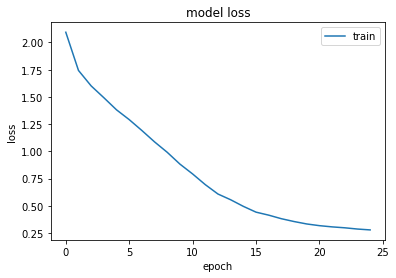

In [14]:
import matplotlib.pyplot as plt
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [15]:
predictions = model.predict_classes(predictors, verbose=0)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [16]:
unique, counts = np.unique(predictions, return_counts=True)
print(np.asarray((unique, counts)).T)

[[   0    2]
 [   1   57]
 [   2   23]
 [   3   42]
 [   4    8]
 [   5   59]
 [   6    2]
 [   7    4]
 [   8    4]
 [   9    2]
 [  10   14]
 [  11    2]
 [  12    4]
 [  13    2]
 [  14    2]
 [  15    2]
 [  16   14]
 [  17    2]
 [  18   24]
 [  19    1]
 [  20    3]
 [  21    2]
 [  22    2]
 [  23   15]
 [  24   18]
 [  25    1]
 [  26    1]
 [  27    3]
 [  28    5]
 [  29    2]
 [  30    1]
 [  31    5]
 [  32    1]
 [  33    1]
 [  34    9]
 [  35    4]
 [  36   11]
 [  38   85]
 [  39   13]
 [  40   58]
 [  41    8]
 [  42    3]
 [  43    8]
 [  44    3]
 [  45    8]
 [  46    2]
 [  47   24]
 [  48    1]
 [  49    2]
 [  50   10]
 [  51    2]
 [  52    8]
 [  57    4]
 [  58    5]
 [  59    2]
 [  60    3]
 [  61    2]
 [  62   11]
 [  63    1]
 [  64   11]
 [  65    2]
 [  66    3]
 [  67   23]
 [  68    4]
 [  69    2]
 [  70    2]
 [  71    4]
 [  72    2]
 [  73    3]
 [  74    4]
 [  75   13]
 [  76    3]
 [  77    2]
 [  78    2]
 [  79    7]
 [  80    3]
 [  81    2]

In [17]:
np.where(predictions==190)

(array([3371]),)

In [18]:
def get_responses(seed_text, n):
    print("Input -", seed_text)
    print("----------------------")
    responses = set()
    trials = 10
    while len(responses) < n and trials > 0:
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = tf.keras.preprocessing.sequence.pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        with strategy.scope():
            predicted_index = model.predict_classes(token_list, verbose=10)
        if predicted_index[0] == len(set(dbscan.labels_)) - 1:
            print("Predicting outside clusters")
            predicted_index = -1

        # randomly pick 1 index
        possible_response = np.where(dbscan.labels_==predicted_index)[0]
        response_index = random.sample(possible_response.tolist(), 1)[0]
        # print(response_index)
        responses.add(output_texts[response_index].replace("\t", "").replace("\n", ""))
        
        trials-=1
        
    for i, response in enumerate(responses):
        print("Response", (i + 1), "->", response)



In [19]:
get_responses("goodbye", 5)

Input - goodbye
----------------------
Response 1 -> in any case thanks for chatting.


In [20]:
get_responses(input_texts[1728], 5)

Input - have a great day.
----------------------
Predicting outside clusters
Predicting outside clusters
Predicting outside clusters
Predicting outside clusters
Predicting outside clusters
Response 1 -> i do especially rap albums. how about you
Response 2 -> um no.
Response 3 -> it's ok. don't really watch it
Response 4 -> really he couldnt pick a more fitting name lol
Response 5 -> me talk pretty one day is a classic.


In [21]:
get_responses(input_texts[3107], 5)

Input - yes me too. great chat. take care
----------------------
Response 1 -> have a good night.


In [22]:
get_responses("hi do you like animals", 5)

Input - hi do you like animals
----------------------
Predicting outside clusters
Predicting outside clusters
Predicting outside clusters
Predicting outside clusters
Predicting outside clusters
Response 1 -> for sure. what's your favorite stephen king movie
Response 2 -> did you see that hbo film leavign neverland
Response 3 -> is he a contender for the dem's presidential candidacy
Response 4 -> i agree with your sentiment.
Response 5 -> no i read the news about the royal family.


In [23]:
get_responses("how are you", 5)

Input - how are you
----------------------
Predicting outside clusters
Predicting outside clusters
Predicting outside clusters
Predicting outside clusters
Predicting outside clusters
Response 1 -> im great are you a religious person
Response 2 -> thanks. same.
Response 3 -> yeah love facebook how about yourself
Response 4 -> yeah. the first president of zimbabwe was called banana
Response 5 -> phone home or die.


In [24]:
get_responses("goodmorning", 5)

Input - goodmorning
----------------------
Response 1 -> in any case thanks for chatting.
